In [1]:
# 라이브러리 로드
import os
import json
import csv
import requests
import folium
import pandas as pd
import numpy as np
import platform
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import re

In [2]:

# 현재 작업 디렉토리 경로 얻기
current_directory = os.getcwd()
# 나눔바른고딕 글꼴 파일 경로 지정
font_path = os.path.join(current_directory, "NanumBarunGothic.ttf")

# 글꼴이 있는지 확인
if os.path.exists(font_path):
    # 폰트 추가
    fm.fontManager.addfont(font_path)

    # 캐시를 새로 고치지 않고 직접 폰트 설정
    font_prop = fm.FontProperties(fname=font_path)
    plt.rc("font", family=font_prop.get_name())
    plt.rcParams["axes.unicode_minus"] = False  # 마이너스 부호 출력 설정

In [53]:
s_data = pd.read_csv('catch_loc_updated_0630.csv')
s_data.head()

,Unnamed: 0,Name,Category,Category_1,Location,Location_1,Label,Rating,Review,avg_lunch,avg_dinner,min_lunch,max_lunch,min_dinner,max_dinner,Location_2
0,0,런던 베이글 뮤지엄 도산,"카페,디저트",카페,도산공원,강남구,웨이팅,4.4,3419,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0,도산공원
1,1,산청숯불가든 마곡,돼지고기구이,한식,마곡,강서구,웨이팅,4.6,583,40000.0,40000.0,20000.0,60000.0,20000.0,60000.0,마곡
2,2,라프레플루트,"카페,디저트",카페,서울숲,성동구,웨이팅,4.3,278,20000.0,20000.0,10000.0,30000.0,10000.0,30000.0,서울숲
3,3,한소반 청계산점,"육류,고기요리",한식,청계산,서초구,웨이팅,4.3,197,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0,청계산
4,4,크레이지카츠,돈가스,한식,합정,마포구,웨이팅,4.7,562,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0,합정


In [54]:
# r_data = s_data[(s_data['Rating'] >= 4.5) & (s_data['Review'] >= 200)]

# 가장 높은 지역구 3개 선택
top_locations = s_data['Location_1'].value_counts().nlargest(4).index
# print(top_locations)

# 선택된 지역구들에 해당하는 데이터 필터링
filtered_data = s_data[s_data['Location_1'].isin(top_locations)]
print(filtered_data)

      Unnamed: 0           Name Category Category_1 Location Location_1  \
0              0  런던 베이글 뮤지엄 도산   카페,디저트         카페     도산공원        강남구   
2              2         라프레플루트   카페,디저트         카페      서울숲        성동구   
4              4         크레이지카츠      돈가스         한식       합정        마포구   
9              9             난포       한식         한식      서울숲        성동구   
10            10         미뉴트빠삐용   카페,디저트         카페   압구정로데오        강남구   
...          ...            ...      ...        ...      ...        ...   
3393        3393       온천집 스키야키     샤브샤브         한식   압구정로데오        강남구   
3394        3394          함루 본점       일식         일식       공덕        마포구   
3395        3395        이치류 한남점      양고기         육류       한남        용산구   
3398        3398      하이디라오 서초점       중식         중식       강남        강남구   
3401        3401       백송한우 청담점    소고기구이         한식       청담        강남구   

       Label  Rating  Review avg_lunch avg_dinner  min_lunch  max_lunch  \
0        웨이팅     4.4    

In [38]:
filtered_data.head()

,Unnamed: 0,Name,Category,Category_1,Location,Location_1,Label,Rating,Review,avg_lunch,avg_dinner,min_lunch,max_lunch,min_dinner,max_dinner,Location_2
0,0,런던 베이글 뮤지엄 도산,"카페,디저트",카페,도산공원,강남구,웨이팅,4.4,3419,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0,도산공원
2,2,라프레플루트,"카페,디저트",카페,서울숲,성동구,웨이팅,4.3,278,20000.0,20000.0,10000.0,30000.0,10000.0,30000.0,서울숲
4,4,크레이지카츠,돈가스,한식,합정,마포구,웨이팅,4.7,562,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0,합정
9,9,난포,한식,한식,서울숲,성동구,웨이팅,4.3,950,30000.0,30000.0,10000.0,50000.0,10000.0,50000.0,서울숲
10,10,미뉴트빠삐용,"카페,디저트",카페,압구정로데오,강남구,웨이팅,4.0,720,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,압구정로데오


In [55]:
# avg_lunch와 avg_dinner 컬럼에서 NA 값을 0으로 대체
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].fillna(0)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].fillna(0)

# avg_lunch와 avg_dinner 컬럼에서 '영업안함'과 '가격변동' 값을 0으로 대체
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].replace(['영업안함', '가격변동'], 0)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].replace(['영업안함', '가격변동'], 0)

# avg_lunch와 avg_dinner 컬럼을 float 타입으로 변환
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].astype(float)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].astype(float)

# 변경된 데이터 확인
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1873 entries, 0 to 3401
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1873 non-null   int64  
 1   Name        1873 non-null   object 
 2   Category    1873 non-null   object 
 3   Category_1  1873 non-null   object 
 4   Location    1873 non-null   object 
 5   Location_1  1873 non-null   object 
 6   Label       1873 non-null   object 
 7   Rating      1873 non-null   float64
 8   Review      1873 non-null   int64  
 9   avg_lunch   1873 non-null   float64
 10  avg_dinner  1873 non-null   float64
 11  min_lunch   1257 non-null   float64
 12  max_lunch   1257 non-null   float64
 13  min_dinner  1809 non-null   float64
 14  max_dinner  1809 non-null   float64
 15  Location_2  1873 non-null   object 
dtypes: float64(7), int64(2), object(7)
memory usage: 248.8+ KB


C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\2514634491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['avg_lunch'] = filtered_data['avg_lunch'].fillna(0)
C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\2514634491.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['avg_dinner'] = filtered_data['avg_dinner'].fillna(0)
C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\2514634491.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

Category_1
한식       243
양식       205
일식       171
주류        63
퓨전        37
카페        25
중식        24
육류        10
아시아음식      8
뷔페         4
Name: count, dtype: int64
790


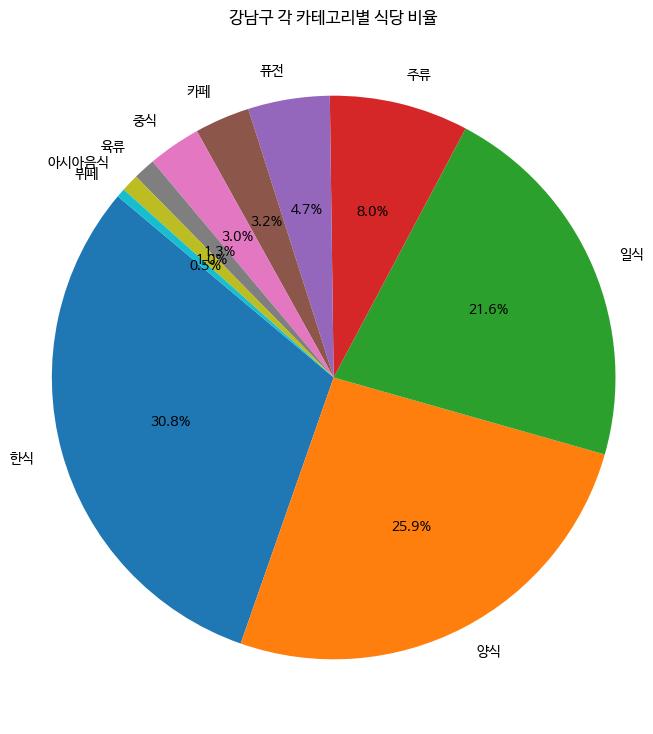

In [56]:
# '강남구'만을 필터링
gangnam_data = filtered_data[filtered_data['Location_1'] == '강남구']


# 강남구에서 각 카테고리별 식당 개수 계산
gangnam_counts = gangnam_data['Category_1'].value_counts()
print(gangnam_counts)
print(gangnam_counts.sum())
# 파이차트 그리기
plt.figure(figsize=(8, 9))
plt.pie(gangnam_counts, labels=gangnam_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('강남구 각 카테고리별 식당 비율')
plt.axis('equal')  # 원형 파이차트로 만들기 위해 설정
plt.show()

In [73]:
import pandas as pd

# 데이터 로드
s_data = pd.read_csv('catch_loc_updated_0630.csv')

# 가장 많은 4개의 지역구 선택
top_locations = s_data['Location_1'].value_counts().nlargest(4).index

# 선택된 지역구들에 해당하는 데이터 필터링
filtered_data = s_data[s_data['Location_1'].isin(top_locations)]

# avg_lunch와 avg_dinner 컬럼에서 NA 값을 0으로 대체
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].fillna(0)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].fillna(0)

# avg_lunch와 avg_dinner 컬럼에서 '영업안함'과 '가격변동' 값을 0으로 대체
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].replace(['영업안함', '가격변동'], 0)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].replace(['영업안함', '가격변동'], 0)

# avg_lunch와 avg_dinner 컬럼을 float 타입으로 변환
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].astype(float)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].astype(float)

# '강남구'만을 필터링
gangnam_data = filtered_data[filtered_data['Location_1'] == '강남구']

# 카테고리별 빈도수 계산 후 상위 3개의 카테고리 추출
top3_categories = gangnam_data['Category_1'].value_counts().nlargest(3).index

# 상위 3개의 카테고리에 해당하는 데이터 필터링
top3_gangnam_data = gangnam_data[gangnam_data['Category_1'].isin(top3_categories)]


# 각 한식, 양식, top3_gangnam_data일식으로 필터링
h_gangnam_data = top3_gangnam_data[top3_gangnam_data['Category_1'] == '한식']
a_gangnam_data = top3_gangnam_data[top3_gangnam_data['Category_1'] == '양식']
j_gangnam_data = top3_gangnam_data[top3_gangnam_data['Category_1'] == '일식']
# 결과 출력
# print(h_gangnam_data)
# print(a_gangnam_data)
# print(j_gangnam_data)


      Unnamed: 0                  Name Category Category_1 Location  \
22            22               오제제 강남점       일식         일식       강남   
67            67                고에몬 강남       일식         일식       강남   
76            76                우와 신사점       일식         일식       신사   
122          122                고급오복수산       일식         일식      압구정   
140          140              연하동 신논현점       일식         일식       강남   
...          ...                   ...      ...        ...      ...   
3281        3281  이자카야나무 서초점 (강남역 3호점)     이자카야         일식       강남   
3282        3282        이자카야나무 강남역CGV점     이자카야         일식       강남   
3298        3298                도톤보리서울     이자카야         일식       신사   
3311        3311              치보 강남신사점       일식         일식       신사   
3383        3383           포사로(fosaro)     이자카야         일식       신사   

     Location_1   Label  Rating  Review  avg_lunch  avg_dinner  min_lunch  \
22          강남구     웨이팅     4.6     410    20000.0     20000.0    1000

C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\2218376319.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['avg_lunch'] = filtered_data['avg_lunch'].fillna(0)
C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\2218376319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['avg_dinner'] = filtered_data['avg_dinner'].fillna(0)
C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\2218376319.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [74]:
h_gangnam_data.head()

,Unnamed: 0,Name,Category,Category_1,Location,Location_1,Label,Rating,Review,avg_lunch,avg_dinner,min_lunch,max_lunch,min_dinner,max_dinner,Location_2
25,25,떡도리탕 강남본점,"닭,오리요리",한식,강남,강남구,웨이팅,4.5,913,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0,강남
39,39,꿉당 신사,돼지고기구이,한식,신사,강남구,웨이팅,4.4,485,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0,신사
46,46,광평 평양냉면갈비 삼성본점,"육류,고기요리",한식,삼성,강남구,웨이팅,4.6,561,45000.0,45000.0,10000.0,80000.0,10000.0,80000.0,삼성
56,56,한미옥 청담본점,"육류,고기요리",한식,청담,강남구,웨이팅,4.5,227,40000.0,50000.0,10000.0,70000.0,20000.0,80000.0,청담
72,72,온천집 스키야키,샤브샤브,한식,압구정로데오,강남구,웨이팅,4.1,1135,55000.0,55000.0,20000.0,90000.0,20000.0,90000.0,압구정로데오


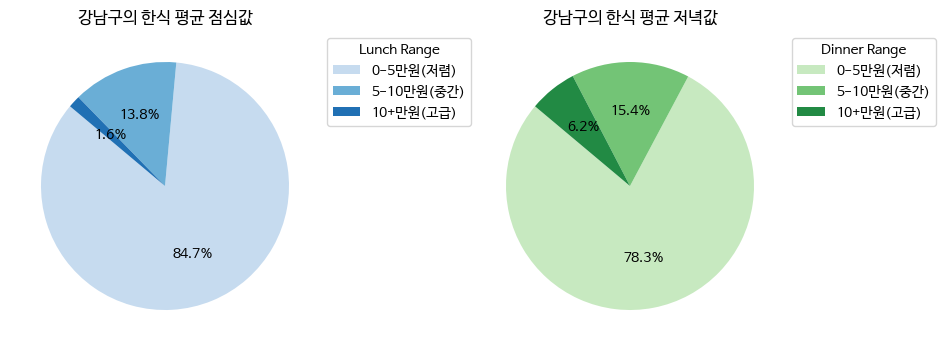

In [76]:
# 가격, 평점, 리뷰 수 범주화
lunch_bins = [0, 50000, 100000, h_gangnam_data['avg_lunch'].max()]
dinner_bins = [0, 50000, 100000, h_gangnam_data['avg_dinner'].max()]


h_gangnam_data['lunch_Binned'] = pd.cut(h_gangnam_data['avg_lunch'], bins=lunch_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])
h_gangnam_data['dinner_Binned'] = pd.cut(h_gangnam_data['avg_dinner'], bins=dinner_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])


# Plotting the distribution of binned Price, Rating, Reviews and Brand distribution
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
plt.subplots_adjust(wspace=0.5)

# Lunch price distribution pie chart
lunch_counts = h_gangnam_data['lunch_Binned'].value_counts()
price_pie = axs[0].pie(lunch_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues', len(lunch_counts)))
axs[0].set_title('강남구의 한식 평균 점심값')
axs[0].legend(price_pie[0], lunch_counts.index, title="Lunch Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

# Dinner price distribution pie chart
dinner_counts = h_gangnam_data['dinner_Binned'].value_counts()
rating_pie = axs[1].pie(dinner_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Greens', len(dinner_counts)))
axs[1].set_title('강남구의 한식 평균 저녁값')
axs[1].legend(rating_pie[0], dinner_counts.index, title="Dinner Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [78]:
a_gangnam_data.head()

,Unnamed: 0,Name,Category,Category_1,Location,Location_1,Label,Rating,Review,avg_lunch,avg_dinner,min_lunch,max_lunch,min_dinner,max_dinner,Location_2
49,49,라브리크 서울,브런치,양식,강남,강남구,웨이팅,4.0,345,25000.0,25000.0,10000.0,40000.0,10000.0,40000.0,강남
115,115,더 타코부스,아메리칸음식,양식,압구정로데오,강남구,웨이팅,4.2,132,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0,압구정로데오
127,127,심퍼티쿠시 가로수길점,유러피안음식,양식,가로수길,강남구,웨이팅,4.6,852,35000.0,35000.0,20000.0,50000.0,20000.0,50000.0,가로수길
145,145,파스타 트리오,파스타,양식,논현,강남구,웨이팅,4.7,18,25000.0,25000.0,10000.0,40000.0,10000.0,40000.0,논현
163,163,82올리언즈 강남점,아메리칸음식,양식,강남,강남구,웨이팅,4.5,155,25000.0,25000.0,10000.0,40000.0,10000.0,40000.0,강남


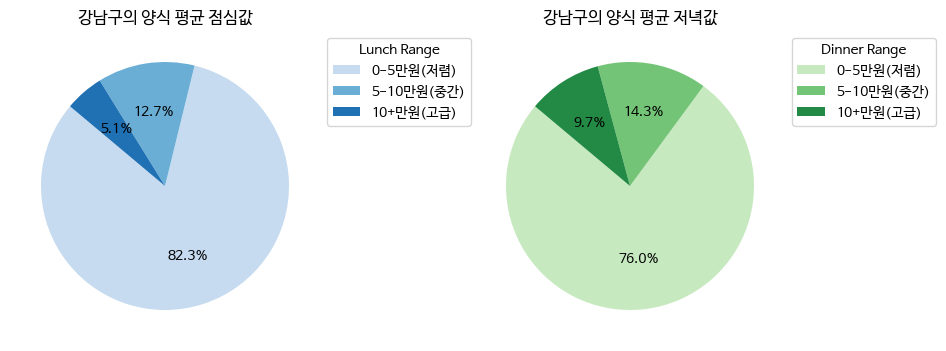

In [80]:
# 가격, 평점, 리뷰 수 범주화
lunch_bins = [0, 50000, 100000, a_gangnam_data['avg_lunch'].max()]
dinner_bins = [0, 50000, 100000, a_gangnam_data['avg_dinner'].max()]


a_gangnam_data['lunch_Binned'] = pd.cut(a_gangnam_data['avg_lunch'], bins=lunch_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])
a_gangnam_data['dinner_Binned'] = pd.cut(a_gangnam_data['avg_dinner'], bins=dinner_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])


# Plotting the distribution of binned Price, Rating, Reviews and Brand distribution
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
plt.subplots_adjust(wspace=0.5)

# Lunch price distribution pie chart
lunch_counts = a_gangnam_data['lunch_Binned'].value_counts()
price_pie = axs[0].pie(lunch_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues', len(lunch_counts)))
axs[0].set_title('강남구의 양식 평균 점심값')
axs[0].legend(price_pie[0], lunch_counts.index, title="Lunch Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

# Dinner price distribution pie chart
dinner_counts = a_gangnam_data['dinner_Binned'].value_counts()
rating_pie = axs[1].pie(dinner_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Greens', len(dinner_counts)))
axs[1].set_title('강남구의 양식 평균 저녁값')
axs[1].legend(rating_pie[0], dinner_counts.index, title="Dinner Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [82]:
j_gangnam_data.head()

,Unnamed: 0,Name,Category,Category_1,Location,Location_1,Label,Rating,Review,avg_lunch,avg_dinner,min_lunch,max_lunch,min_dinner,max_dinner,Location_2
22,22,오제제 강남점,일식,일식,강남,강남구,웨이팅,4.6,410,20000.0,20000.0,10000.0,30000.0,10000.0,30000.0,강남
67,67,고에몬 강남,일식,일식,강남,강남구,웨이팅,4.1,449,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0,강남
76,76,우와 신사점,일식,일식,신사,강남구,웨이팅,4.5,137,15000.0,15000.0,10000.0,20000.0,10000.0,20000.0,신사
122,122,고급오복수산,일식,일식,압구정,강남구,웨이팅,4.5,359,35000.0,35000.0,10000.0,60000.0,10000.0,60000.0,압구정
140,140,연하동 신논현점,일식,일식,강남,강남구,웨이팅,4.7,238,20000.0,20000.0,10000.0,30000.0,10000.0,30000.0,강남


C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\1493928781.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j_gangnam_data['lunch_Binned'] = pd.cut(j_gangnam_data['avg_lunch'], bins=lunch_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])
C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\1493928781.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j_gangnam_data['dinner_Binned'] = pd.cut(j_gangnam_data['avg_dinner'], bins=dinner_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])


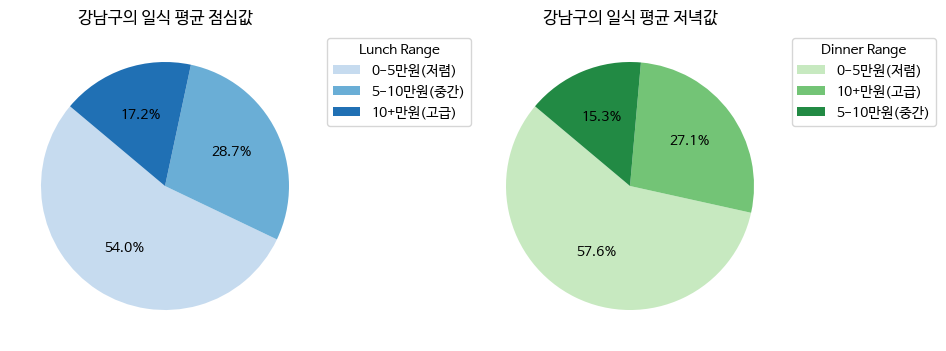

In [84]:
# 가격, 평점, 리뷰 수 범주화
lunch_bins = [0, 50000, 100000, j_gangnam_data['avg_lunch'].max()]
dinner_bins = [0, 50000, 100000, j_gangnam_data['avg_dinner'].max()]


j_gangnam_data['lunch_Binned'] = pd.cut(j_gangnam_data['avg_lunch'], bins=lunch_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])
j_gangnam_data['dinner_Binned'] = pd.cut(j_gangnam_data['avg_dinner'], bins=dinner_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])


# Plotting the distribution of binned Price, Rating, Reviews and Brand distribution
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
plt.subplots_adjust(wspace=0.5)

# Lunch price distribution pie chart
lunch_counts = j_gangnam_data['lunch_Binned'].value_counts()
price_pie = axs[0].pie(lunch_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues', len(lunch_counts)))
axs[0].set_title('강남구의 일식 평균 점심값')
axs[0].legend(price_pie[0], lunch_counts.index, title="Lunch Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

# Dinner price distribution pie chart
dinner_counts = j_gangnam_data['dinner_Binned'].value_counts()
rating_pie = axs[1].pie(dinner_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Greens', len(dinner_counts)))
axs[1].set_title('강남구의 일식 평균 저녁값')
axs[1].legend(rating_pie[0], dinner_counts.index, title="Dinner Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [94]:
import pandas as pd

# 데이터 로드
s_data = pd.read_csv('catch_loc_updated_0630.csv')

# 가장 많은 4개의 지역구 선택
top_locations = s_data['Location_1'].value_counts().nlargest(4).index

# 선택된 지역구들에 해당하는 데이터 필터링
filtered_data = s_data[s_data['Location_1'].isin(top_locations)]

# avg_lunch와 avg_dinner 컬럼에서 NA 값을 0으로 대체
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].fillna(0)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].fillna(0)

# avg_lunch와 avg_dinner 컬럼에서 '영업안함'과 '가격변동' 값을 0으로 대체
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].replace(['영업안함', '가격변동'], 0)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].replace(['영업안함', '가격변동'], 0)

# avg_lunch와 avg_dinner 컬럼을 float 타입으로 변환
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].astype(float)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].astype(float)

# '강남구'만을 필터링
gangnam_data = filtered_data[filtered_data['Location_1'] == '마포구']

# 카테고리별 빈도수 계산 후 상위 3개의 카테고리 추출
top3_categories = gangnam_data['Category_1'].value_counts().nlargest(3).index

# 상위 3개의 카테고리에 해당하는 데이터 필터링
top3_gangnam_data = gangnam_data[gangnam_data['Category_1'].isin(top3_categories)]


# 각 한식, 양식, top3_gangnam_data일식으로 필터링
h_gangnam_data = top3_gangnam_data[top3_gangnam_data['Category_1'] == '한식']
a_gangnam_data = top3_gangnam_data[top3_gangnam_data['Category_1'] == '양식']
j_gangnam_data = top3_gangnam_data[top3_gangnam_data['Category_1'] == '일식']
# 결과 출력
# print(h_gangnam_data)
# print(a_gangnam_data)
# print(j_gangnam_data)


C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\781444102.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['avg_lunch'] = filtered_data['avg_lunch'].fillna(0)
C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\781444102.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['avg_dinner'] = filtered_data['avg_dinner'].fillna(0)
C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\781444102.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\2147145677.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_gangnam_data['lunch_Binned'] = pd.cut(h_gangnam_data['avg_lunch'], bins=lunch_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])
C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\2147145677.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_gangnam_data['dinner_Binned'] = pd.cut(h_gangnam_data['avg_dinner'], bins=dinner_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])


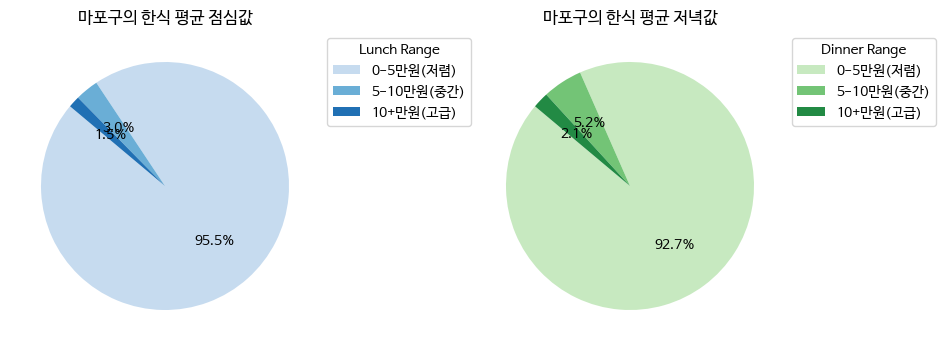

In [95]:
# 가격, 평점, 리뷰 수 범주화
lunch_bins = [0, 50000, 100000, h_gangnam_data['avg_lunch'].max()]
dinner_bins = [0, 50000, 100000, h_gangnam_data['avg_dinner'].max()]


h_gangnam_data['lunch_Binned'] = pd.cut(h_gangnam_data['avg_lunch'], bins=lunch_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])
h_gangnam_data['dinner_Binned'] = pd.cut(h_gangnam_data['avg_dinner'], bins=dinner_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])


# Plotting the distribution of binned Price, Rating, Reviews and Brand distribution
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
plt.subplots_adjust(wspace=0.5)

# Lunch price distribution pie chart
lunch_counts = h_gangnam_data['lunch_Binned'].value_counts()
price_pie = axs[0].pie(lunch_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues', len(lunch_counts)))
axs[0].set_title('마포구의 한식 평균 점심값')
axs[0].legend(price_pie[0], lunch_counts.index, title="Lunch Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

# Dinner price distribution pie chart
dinner_counts = h_gangnam_data['dinner_Binned'].value_counts()
rating_pie = axs[1].pie(dinner_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Greens', len(dinner_counts)))
axs[1].set_title('마포구의 한식 평균 저녁값')
axs[1].legend(rating_pie[0], dinner_counts.index, title="Dinner Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\455805518.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_gangnam_data['lunch_Binned'] = pd.cut(a_gangnam_data['avg_lunch'], bins=lunch_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])
C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\455805518.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_gangnam_data['dinner_Binned'] = pd.cut(a_gangnam_data['avg_dinner'], bins=dinner_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])


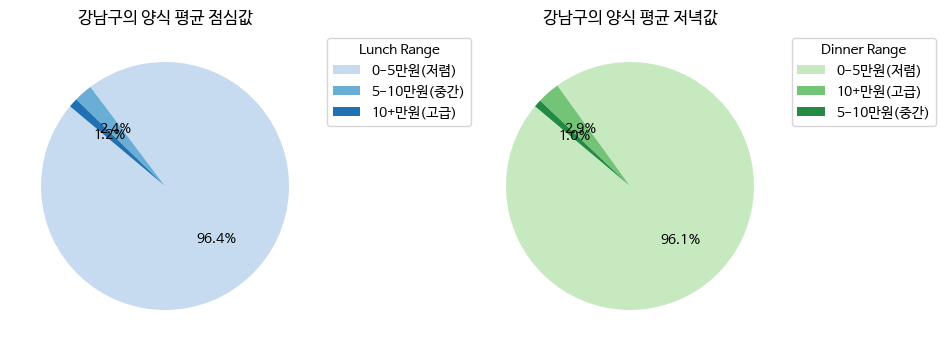

In [92]:
# 가격, 평점, 리뷰 수 범주화
lunch_bins = [0, 50000, 100000, a_gangnam_data['avg_lunch'].max()]
dinner_bins = [0, 50000, 100000, a_gangnam_data['avg_dinner'].max()]


a_gangnam_data['lunch_Binned'] = pd.cut(a_gangnam_data['avg_lunch'], bins=lunch_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])
a_gangnam_data['dinner_Binned'] = pd.cut(a_gangnam_data['avg_dinner'], bins=dinner_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])


# Plotting the distribution of binned Price, Rating, Reviews and Brand distribution
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
plt.subplots_adjust(wspace=0.5)

# Lunch price distribution pie chart
lunch_counts = a_gangnam_data['lunch_Binned'].value_counts()
price_pie = axs[0].pie(lunch_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues', len(lunch_counts)))
axs[0].set_title('마포구의 양식 평균 점심값')
axs[0].legend(price_pie[0], lunch_counts.index, title="Lunch Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

# Dinner price distribution pie chart
dinner_counts = a_gangnam_data['dinner_Binned'].value_counts()
rating_pie = axs[1].pie(dinner_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Greens', len(dinner_counts)))
axs[1].set_title('마포구의 양식 평균 저녁값')
axs[1].legend(rating_pie[0], dinner_counts.index, title="Dinner Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [101]:
j_gangnam_data.to_excel('a.xlsx')

C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\1002271996.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j_gangnam_data['lunch_Binned'] = pd.cut(j_gangnam_data['avg_lunch'], bins=lunch_bins, labels=['0-5만원(저렴)', '5-10만원(중간)'])
C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\1002271996.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j_gangnam_data['dinner_Binned'] = pd.cut(j_gangnam_data['avg_dinner'], bins=dinner_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])


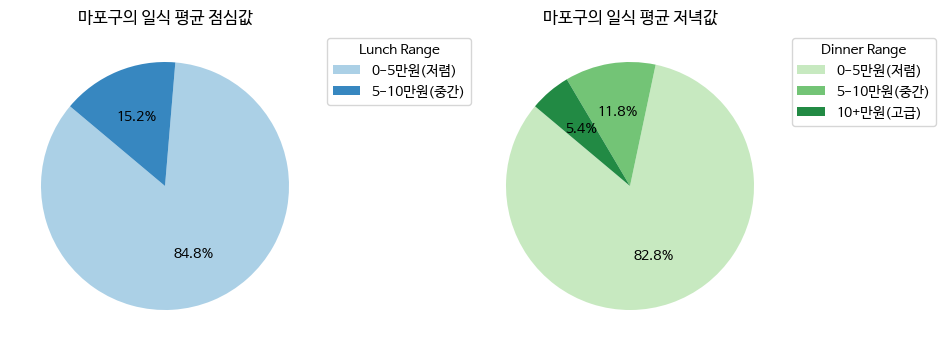

In [102]:
# 가격, 평점, 리뷰 수 범주화
lunch_bins = [0, 50000, 100000]
dinner_bins = [0, 50000, 100000, j_gangnam_data['avg_dinner'].max()]


j_gangnam_data['lunch_Binned'] = pd.cut(j_gangnam_data['avg_lunch'], bins=lunch_bins, labels=['0-5만원(저렴)', '5-10만원(중간)'])
j_gangnam_data['dinner_Binned'] = pd.cut(j_gangnam_data['avg_dinner'], bins=dinner_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])


# Plotting the distribution of binned Price, Rating, Reviews and Brand distribution
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
plt.subplots_adjust(wspace=0.5)

# Lunch price distribution pie chart
lunch_counts = j_gangnam_data['lunch_Binned'].value_counts()
price_pie = axs[0].pie(lunch_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues', len(lunch_counts)))
axs[0].set_title('마포구의 일식 평균 점심값')
axs[0].legend(price_pie[0], lunch_counts.index, title="Lunch Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

# Dinner price distribution pie chart
dinner_counts = j_gangnam_data['dinner_Binned'].value_counts()
rating_pie = axs[1].pie(dinner_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Greens', len(dinner_counts)))
axs[1].set_title('마포구의 일식 평균 저녁값')
axs[1].legend(rating_pie[0], dinner_counts.index, title="Dinner Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [116]:
import pandas as pd

# 데이터 로드
s_data = pd.read_csv('catch_loc_updated_0630.csv')

# 가장 많은 4개의 지역구 선택
top_locations = s_data['Location_1'].value_counts().nlargest(4).index

# 선택된 지역구들에 해당하는 데이터 필터링
filtered_data = s_data[s_data['Location_1'].isin(top_locations)]

# avg_lunch와 avg_dinner 컬럼에서 NA 값을 0으로 대체
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].fillna(0)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].fillna(0)

# avg_lunch와 avg_dinner 컬럼에서 '영업안함'과 '가격변동' 값을 0으로 대체
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].replace(['영업안함', '가격변동'], 0)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].replace(['영업안함', '가격변동'], 0)

# avg_lunch와 avg_dinner 컬럼을 float 타입으로 변환
filtered_data['avg_lunch'] = filtered_data['avg_lunch'].astype(float)
filtered_data['avg_dinner'] = filtered_data['avg_dinner'].astype(float)

# '강남구'만을 필터링
gangnam_data = filtered_data[filtered_data['Location_1'] == '용산구']

# 카테고리별 빈도수 계산 후 상위 3개의 카테고리 추출
top3_categories = gangnam_data['Category_1'].value_counts().nlargest(3).index

# 상위 3개의 카테고리에 해당하는 데이터 필터링
top3_gangnam_data = gangnam_data[gangnam_data['Category_1'].isin(top3_categories)]


# 각 한식, 양식, top3_gangnam_data일식으로 필터링
h_gangnam_data = top3_gangnam_data[top3_gangnam_data['Category_1'] == '한식']
a_gangnam_data = top3_gangnam_data[top3_gangnam_data['Category_1'] == '양식']
j_gangnam_data = top3_gangnam_data[top3_gangnam_data['Category_1'] == '일식']
# 결과 출력
# print(h_gangnam_data)
# print(a_gangnam_data)
# print(j_gangnam_data)


C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\692755514.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['avg_lunch'] = filtered_data['avg_lunch'].fillna(0)
C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\692755514.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['avg_dinner'] = filtered_data['avg_dinner'].fillna(0)
C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\692755514.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [117]:
h_gangnam_data

,Unnamed: 0,Name,Category,Category_1,Location,Location_1,Label,Rating,Review,avg_lunch,avg_dinner,min_lunch,max_lunch,min_dinner,max_dinner,Location_2


In [112]:
h_gangnam_data.to_excel('b.xlsx')

In [109]:
# 가격, 평점, 리뷰 수 범주화
lunch_bins = [0, 50000, 150000]
dinner_bins = [0, 50000, 100000, h_gangnam_data['avg_dinner'].max()]


h_gangnam_data['lunch_Binned'] = pd.cut(h_gangnam_data['avg_lunch'], bins=lunch_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])
h_gangnam_data['dinner_Binned'] = pd.cut(h_gangnam_data['avg_dinner'], bins=dinner_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])


# Plotting the distribution of binned Price, Rating, Reviews and Brand distribution
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
plt.subplots_adjust(wspace=0.5)

# Lunch price distribution pie chart
lunch_counts = h_gangnam_data['lunch_Binned'].value_counts()
price_pie = axs[0].pie(lunch_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues', len(lunch_counts)))
axs[0].set_title('마포구의 한식 평균 점심값')
axs[0].legend(price_pie[0], lunch_counts.index, title="Lunch Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

# Dinner price distribution pie chart
dinner_counts = h_gangnam_data['dinner_Binned'].value_counts()
rating_pie = axs[1].pie(dinner_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Greens', len(dinner_counts)))
axs[1].set_title('마포구의 한식 평균 저녁값')
axs[1].legend(rating_pie[0], dinner_counts.index, title="Dinner Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

ValueError: Bin labels must be one fewer than the number of bin edges

C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\2027183227.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_gangnam_data['lunch_Binned'] = pd.cut(a_gangnam_data['avg_lunch'], bins=lunch_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])
C:\Users\RYS\AppData\Local\Temp\ipykernel_24704\2027183227.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_gangnam_data['dinner_Binned'] = pd.cut(a_gangnam_data['avg_dinner'], bins=dinner_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])


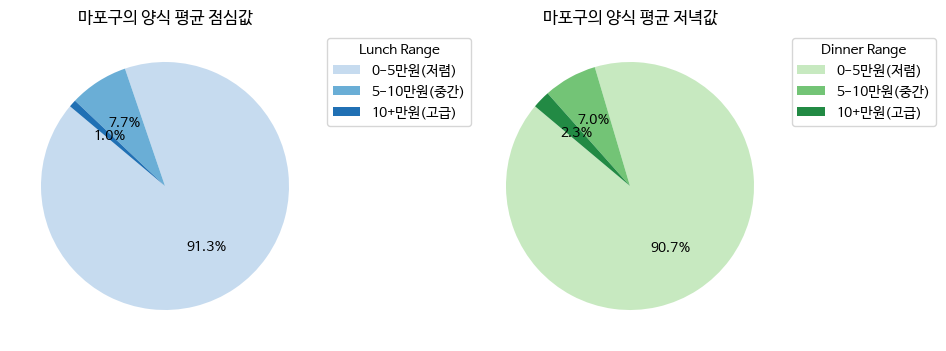

In [105]:
# 가격, 평점, 리뷰 수 범주화
lunch_bins = [0, 50000, 100000, a_gangnam_data['avg_lunch'].max()]
dinner_bins = [0, 50000, 100000, a_gangnam_data['avg_dinner'].max()]


a_gangnam_data['lunch_Binned'] = pd.cut(a_gangnam_data['avg_lunch'], bins=lunch_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])
a_gangnam_data['dinner_Binned'] = pd.cut(a_gangnam_data['avg_dinner'], bins=dinner_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])


# Plotting the distribution of binned Price, Rating, Reviews and Brand distribution
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
plt.subplots_adjust(wspace=0.5)

# Lunch price distribution pie chart
lunch_counts = a_gangnam_data['lunch_Binned'].value_counts()
price_pie = axs[0].pie(lunch_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues', len(lunch_counts)))
axs[0].set_title('마포구의 양식 평균 점심값')
axs[0].legend(price_pie[0], lunch_counts.index, title="Lunch Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

# Dinner price distribution pie chart
dinner_counts = a_gangnam_data['dinner_Binned'].value_counts()
rating_pie = axs[1].pie(dinner_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Greens', len(dinner_counts)))
axs[1].set_title('마포구의 양식 평균 저녁값')
axs[1].legend(rating_pie[0], dinner_counts.index, title="Dinner Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [107]:
# 가격, 평점, 리뷰 수 범주화
lunch_bins = [0, 50000, 100000, j_gangnam_data['avg_lunch'].max()]
dinner_bins = [0, 50000, 100000, j_gangnam_data['avg_dinner'].max()]


j_gangnam_data['lunch_Binned'] = pd.cut(j_gangnam_data['avg_lunch'], bins=lunch_bins, labels=['0-5만원(저렴)', '5-10만원(중간)'])
j_gangnam_data['dinner_Binned'] = pd.cut(j_gangnam_data['avg_dinner'], bins=dinner_bins, labels=['0-5만원(저렴)', '5-10만원(중간)', '10+만원(고급)'])


# Plotting the distribution of binned Price, Rating, Reviews and Brand distribution
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
plt.subplots_adjust(wspace=0.5)

# Lunch price distribution pie chart
lunch_counts = j_gangnam_data['lunch_Binned'].value_counts()
price_pie = axs[0].pie(lunch_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues', len(lunch_counts)))
axs[0].set_title('마포구의 일식 평균 점심값')
axs[0].legend(price_pie[0], lunch_counts.index, title="Lunch Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

# Dinner price distribution pie chart
dinner_counts = j_gangnam_data['dinner_Binned'].value_counts()
rating_pie = axs[1].pie(dinner_counts, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Greens', len(dinner_counts)))
axs[1].set_title('마포구의 일식 평균 저녁값')
axs[1].legend(rating_pie[0], dinner_counts.index, title="Dinner Range", loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

ValueError: Bin labels must be one fewer than the number of bin edges